In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass#print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Download Youtube videos


In [13]:
! pip install pytube
import pandas as pd
import numpy as np
import cv2
import os
from pytube import YouTube

#paths for training and lables file in dataset

train_text = r'/kaggle/input/sports-1m-dataset/original/train_partition.txt'
labels_text=r'/kaggle/input/sports-1m-dataset/labels.txt'

#creating dataframe with the text data

df = pd.read_csv(train_text, sep='\s+', header=None, names=['URL', 'ID'])
labels = pd.read_csv(labels_text,header=None,names=['Games'])
#print(df[:5])
c= df['URL'][7]
print(c)
#print(labels.iloc[int(c)])
frames =[df,labels]
#print(labels[:3])
combined =pd.concat(frames,ignore_index=True)

#downloading the video from the link 

def download_video(video_link, output_folder='videos'):
    try:
        yt = YouTube(video_link)
        chosen_stream = yt.streams.filter(res="360p", file_extension="mp4").first()
        chosen_stream.download(output_path=output_folder)
        print(f'Video downloaded successfully')
    except Exception as e:
        print(f'Error downloading video: {e}')
        
output_folder = 'videos'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i in range(0):
    link = df['URL'][i]
    download_video(link)
    
def delete_videos(video_folder='videos'):
    try:
        # List all files in the video folder
        video_files = os.listdir(video_folder)

        # Iterate through the files and delete each one
        for video_file in video_files:
            video_path = os.path.join(video_folder, video_file)
            os.remove(video_path)

        # Remove the video folder itself
        os.rmdir(video_folder)

        print(f'Videos deleted successfully')
    except Exception as e:
        print(f'Error deleting videos: {e}')

https://www.youtube.com/watch?v=AZM37_FqL5w
Video downloaded successfully


In [15]:
download_video('https://youtube.com/shorts/vlUuA963S5I?si=_IbSBCAKLAcBjvqL')

Video downloaded successfully


In [8]:
# Extracting frames from the Video and then saving the pictures
def extract_frames(video_path, output_folder='frames', frame_interval=5):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the frames per second (fps) and total number of frames
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame interval based on the specified interval
    frame_interval = max(1, int(fps * frame_interval))

    # Loop through the frames and save every nth frame
    for frame_num in range(0, total_frames, frame_interval):
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

        # Read the frame
        ret, frame = cap.read()

        # Save the frame as an image
        if ret:
            frame_path = os.path.join(output_folder, f'frame_{frame_num}.jpg')
            cv2.imwrite(frame_path, frame)

    # Release the video capture object
    cap.release()

    print(f'Frames extracted successfully. Check the \'{output_folder}\' folder.')

In [18]:
extract_frames('/kaggle/working/videos/😍✨Football Lover❤Motivation WhatsApp status Tamilshorts  supportme PmCreationTamil.mp4',output_folder='football',frame_interval=5)

Frames extracted successfully. Check the 'football' folder.


 # Training the Model

In [9]:
import tensorflow as tf
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
warnings.filterwarnings('ignore')


In [10]:
# Path of the images and text file
images_path = '/kaggle/input/flickr8k/Images'
data =pd.read_csv('/kaggle/input/flickr8k/captions.txt')
#data.head()

In [11]:
def read_image(path,img_size=224):
    img =load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img =img/255
    return img

In [7]:
def display_imgs(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        image = read_image(f'{images_path}/{temp_df.image[i]}')
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i],20)))
        plt.axis('off')

In [40]:
def text_processing(data):
    data['caption'] = data['caption'].apply(lambda x:x.lower())
    data['caption'] = data['caption'].apply(lambda x:x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x:x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x:" ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = 'startseq '+data['caption']+' endseq'
    
    return data
data_processed = text_processing(data)


In [41]:
captions =data_processed['caption'].tolist()
captions[0]

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

In [42]:

# Creating a word tokenizer
tokenizer =Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index)+1

# creating max_length param to gert the padding length
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
#print(images)
n_images =len(images)
split_index = round(0.85*n_images)

# splitting data for training and testing
train_images = images[:split_index]
test_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test =data[data['image'].isin(test_images)]

train.reset_index(inplace =True,drop =True)
test.reset_index(inplace =True,drop =True)
#tokenizer.texts_to_sequences([captions[8]])[0]

In [22]:
model =DenseNet201()
fe = Model(inputs =model.input,outputs =model.layers[-2].output)

In [12]:
# feature extraction from the images using DenseNet201.

def ext_features():
    features = {}
    for image in tqdm(images):
        img = read_image(f'/kaggle/input/flickr8k/Images/{image}')
        img =np.expand_dims(img,axis=0)
        feature =fe.predict(img,verbose=0)
        features[image] =feature
    return features

In [13]:
pickle_file = 'features.pickle'
    
# Check if the pickle file already exists
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        features = pickle.load(f)
else:
    features = ext_features()
    with open(pickle_file, 'wb') as f:
            pickle.dump(features, f)


100%|██████████| 8091/8091 [13:25<00:00, 10.04it/s]


In [14]:
#print(features['1000268201_693b08cb0e.jpg'])

# Extracting individual features

def ind_features(path,image):
    features ={}
    img =read_image(f'{path}/{image}')
    img =np.expand_dims(img,axis=0)
    feature =fe.predict(img,verbose=0)
    features[image] =feature
    return features

In [15]:
class CustomDataGeneratot(Sequence):
    def __init__(self,df,X_col,y_col,batch_size,directory,tokenizer,vocab_size,max_length,features,shuffle=True):
        self.df=df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df =self.df.sample(frac =1).reset_index(drop=True)
    def __len__(self):
        return self.n//self.batch_size
    def __getitem__(self,index):
        batch =self.df.iloc[index*self.batch_size:(index+1)*self.batch_size,:]
        X1,X2,y =self.__get_data(batch)
        return (X1,X2),y
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


In [16]:
input1 = Input(shape=1920,)
input2 = Input(shape=(max_length,))

img_features = Dense(256,activation='relu')(input1)
img_features_reshaped =Reshape((1,256),input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size,256,mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features =LSTM(256)(merged)

x=Dropout(0.5)(sentence_features)
x=add([x,img_features])
x=Dense(128,activation ='relu')(x)
x=Dropout(0.5)(x)
output =Dense(vocab_size,activation='softmax')(x)
caption_model =Model(inputs=[input1,input2],outputs =output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [17]:
train_generator =CustomDataGeneratot(df=train,X_col='image',y_col='caption',batch_size =64,directory=images_path,tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)
validation_generator = CustomDataGeneratot(df=test,X_col='image',y_col='caption',batch_size =64,directory=images_path,tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)


In [18]:
model_name = 'image_captioning_model.h5'

checkpoint = ModelCheckpoint(model_name,
                            monitor='val_loss',
                            mode='min',
                            save_best_only =True,
                            verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [19]:
#training = caption_model.fit(train_generator,
#                            epochs=100,
#                            validation_data=validation_generator,
#                            callbacks=[checkpoint,learning_rate_reduction])

In [31]:
model_path = '/kaggle/input/modelll/image_captioning_model (2).h5'
loaded_model = tf.keras.models.load_model(model_path)

In [32]:
def retokenizer(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [33]:
def remove_start_end_tokens(sentence):
    start_token = 'startseq'
    end_token = 'endseq'

    # Check if both start and end tokens are present in the sentence
    if start_token in sentence and end_token in sentence:
        # Remove both start and end tokens
        cleaned_sentence = sentence.replace(start_token, '').replace(end_token, '')
        # Remove extra whitespaces
        cleaned_sentence = ' '.join(cleaned_sentence.split())
        return cleaned_sentence
    else:
        # If start or end token is not found, return the original sentence
        return sentence

In [34]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = retokenizer(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break

    in_text =remove_start_end_tokens(in_text)
       
    return in_text 

In [24]:
samples = test.sample(15)
#print(samples[:3])
samples.reset_index(drop=True,inplace=True)


In [25]:
for index , record in samples.iterrows():
    img = load_img(os.path.join(images_path,record['image']),target_size =(224,224))
    img =img_to_array(img)
    img =img/255
    caption = predict_caption(loaded_model,record['image'],tokenizer,max_length,features)
    
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 20ms/step


In [26]:
video = r'/kaggle/working/videos/Capoeira regional Cuba Habana2.mp4'
extract_frames(video)

Frames extracted successfully. Check the 'frames' folder.


[h264 @ 0x5d4dee1c0600] Missing reference picture, default is 65562
[h264 @ 0x5d4dfbcd0440] mmco: unref short failure
[h264 @ 0x5d4dfbcd0440] mmco: unref short failure


In [23]:
path = '/kaggle/working/football'
vid_images = os.listdir(path)
print(vid_images)

['frame_300.jpg', 'frame_600.jpg', 'frame_750.jpg', 'frame_150.jpg', 'frame_0.jpg', 'frame_450.jpg']


In [35]:
def ext_features(path):
    features = {}
    for image in tqdm(vid_images):
        img = read_image(f'{path}/{image}')
        img =np.expand_dims(img,axis=0)
        feature =fe.predict(img,verbose=0)
        features[image] =feature
    return features

In [36]:
vid_features = ext_features(path)

100%|██████████| 6/6 [00:00<00:00,  9.67it/s]


In [43]:
gen_captions = {}
for image in vid_images:
    vid_captions = predict_caption(loaded_model,image,tokenizer,max_length,vid_features)
    gen_captions[image] = vid_captions

1/1 [==============================] - 0s 22ms/step


In [78]:
# Assuming gen_captions is the dictionary containing image names and generated captions

gen_captions_df = pd.DataFrame(list(gen_captions.items()), columns=['image', 'caption'])
print(gen_captions_df['caption'])

0    man in white shirt is standing on the ground
1               two boys are playing in the grass
2                     boy is playing in the water
3    man in white shirt is standing on the ground
4    man in white shirt is standing on the ground
5    man in white shirt is standing on the ground
Name: caption, dtype: object


In [80]:
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np

# Sample data
#gen_captions_df = {'caption': ['football is a great sport', 'basketball is fun', 'soccer is popular', 'tennis is exciting']}

# Combine all captions into a single string
all_captions = ' '.join(gen_captions_df['caption'])

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# Tokenize and convert the text to tensors
inputs = tokenizer(all_captions, return_tensors="pt", padding=True, truncation=True, max_length=50)  # Increase max_length as needed

# Forward pass through the model
outputs = model(**inputs)

# Extract the hidden states (word embeddings) from the last layer
last_hidden_states = outputs.last_hidden_state

# Choose a specific token position (e.g., the first token)
target_token_position = 1  # Adjust as needed

# Get the embedding for the chosen token position
target_embedding = last_hidden_states[:, target_token_position, :]

# Convert the embedding to a numpy array
target_embedding = target_embedding.detach().numpy()

# Define a list of words for comparison
word_list = ['football', 'basketball', 'soccer', 'tennis', 'golf', 'hockey', 'boxing', 'surfing', 'running', 'swimming']

# Tokenize and convert the words to tensors
word_inputs = tokenizer(word_list, return_tensors="pt", padding=True, truncation=True, max_length=50)  # Increase max_length as needed

# Forward pass through the model for the word embeddings
word_outputs = model(**word_inputs)

# Extract the hidden states (word embeddings) from the last layer for the words
word_hidden_states = word_outputs.last_hidden_state

# Choose the same token position as the target_token_position
word_embeddings = word_hidden_states[:, target_token_position, :].detach().numpy()

# Compute cosine similarity between target_embedding and word_embeddings
similarities = cosine_similarity(target_embedding, word_embeddings)

# Find the index of the most similar word
most_similar_index = np.argmax(similarities)

# Print the most similar word
most_similar_word = word_list[most_similar_index]
print(f"Most similar word: {most_similar_word}")


Most similar word: swimming


In [45]:
def display_imgs(temp_df,path):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        image = read_image(f'{path}/{temp_df.image[i]}')
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i],20)))
        plt.axis('off')

KeyError: 6

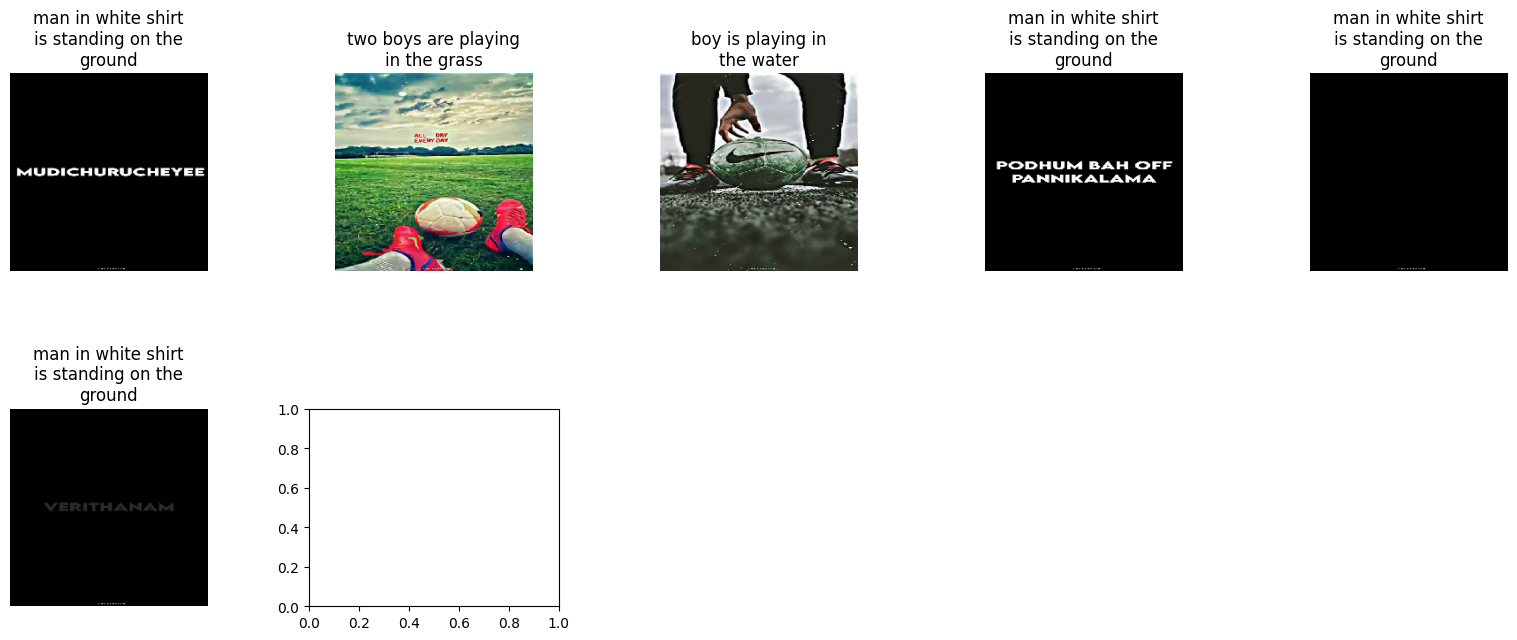

In [48]:
display_imgs(gen_captions_df,'/kaggle/working/football')

# creating the words from the captions

In [49]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string


all_captions = ' '.join(gen_captions_df['caption'])
tokens = word_tokenize(all_captions)
stop_words = set(stopwords.words("english"))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
print(filtered_tokens)


['man', 'white', 'shirt', 'standing', 'ground', 'two', 'boys', 'playing', 'grass', 'boy', 'playing', 'water', 'man', 'white', 'shirt', 'standing', 'ground', 'man', 'white', 'shirt', 'standing', 'ground', 'man', 'white', 'shirt', 'standing', 'ground']


In [2]:
# Assuming you have a DataFrame 'samples' with columns 'image' and 'caption'
# Ground truth captions should be in a dictionary format, where keys are image IDs and values are lists of reference captions

ground_truth = {}
for index, record in samples.iterrows():

    image_id = record['image']# You might need to map your own image IDs
    caption = [record['caption']]  # Replace 'ground_truth_caption' with the actual column name
    ground_truth[image_id] = caption
l =list(ground_truth.values())
print(l[0])
# Predicted captions should be in a dictionary format as well
predicted_captions = {}
for index, record in samples.iterrows():
    img = load_img(os.path.join(images_path,record['image']),target_size =(224,224))
    img =img_to_array(img)
    img =img/255
    image_id = index
    caption = predict_caption(loaded_model,record['image'],tokenizer,max_length,features)
    predicted_captions[image_id] = [caption]
a= list(predicted_captions.values())
print(a[0])

NameError: name 'samples' is not defined

In [6]:
import spacy

# Load pre-trained word embeddings model
nlp = spacy.load("en_core_web_md")

# Sample sentences
sentence1 = nlp('an in white shirt is standing in front of the street')
sentence2 = nlp("AA person in a white shirt standing in front of a building")

# Calculate similarity between sentences
similarity = sentence1.similarity(sentence2)
print("Word Embeddings Similarity:", similarity)


Word Embeddings Similarity: 0.8722259729552715


# CrossValidation


In [2]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Sample data (replace with your data)

print(gen_captions_df['caption'])
# Combine all captions into a single string
all_captions = ' '.join(gen_captions_df['caption'])

# Tokenize and preprocess the text
tokens = word_tokenize(all_captions.lower())  # Convert to lowercase for consistency
stop_words = set(stopwords.words("english"))
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

# Create and train a Word2Vec model
model = Word2Vec([filtered_tokens], vector_size=100, window=5, min_count=1, workers=4)

# Find similar words or synonyms
similar_words = model.wv.most_similar('football', topn=5)

# Print the similar words
print(similar_words)


NameError: name 'gen_captions_df' is not defined

In [1]:
from transformers import pipeline

# Define a function to generate hashtags using a language model
def generate_hashtags_with_model(similar_word, num_hashtags=10):
    # Load the text generation pipeline with a suitable language model
    text_generator = pipeline("text-generation", model="EleutherAI/gpt-neo-2.7B", max_length=50, device=0)

    # Generate text based on the similar word
    generated_text = text_generator(similar_word, max_length=50, num_return_sequences=num_hashtags)

    # Extract generated hashtags from the generated text
    generated_hashtags = [sequence['generated_text'].split()[-1] for sequence in generated_text]

    return generated_hashtags

# Get the most similar word
most_similar_word = "swimming"

# Generate 10 trending hashtags related to swimming using a transformer model
trending_hashtags_with_model = generate_hashtags_with_model(most_similar_word, num_hashtags=10)

# Print the generated hashtags
print("Trending Hashtags (with Transformer Model):")
for hashtag in trending_hashtags_with_model:
    print(hashtag)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Trending Hashtags (with Transformer Model):
to
only
to
&
I
like
wander
at
of
morning,
